# **NLP Disaster Tweets Kaggle Mini-Project**
Table of Contents:
* [Brief Description of the Problem/Data](#brief)
* [Load Environment](#environment)
* [Exploratory Data Analysis (EDA)](#eda)
* [Model Architecture](#model)
* [Results and Analysis ](#results)
* [Conclusion](#conclusion)
* [Submission](#submission)
* [Reference](#ref)


<a id="brief"></a>
# **Brief Description of the Problem/Data**

This dataset and task can be found on [kaggle](https://www.kaggle.com/c/nlp-getting-started/overview). The task is to create an algorithm of Natural Language Processing (NLP) to identify which Tweets are about real disasters and which ones are not. 

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). But, it’s not always clear whether a person’s words are actually announcing a disaster. In this tasks, we’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. 

Each sample in the train and test set has the following information:
* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

<a id="environment"></a>
# **Load Environment**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.regularizers import l2

In [2]:
# Ensure we have downloaded the necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Wenyun
[nltk_data]     HE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Wenyun
[nltk_data]     HE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<a id="eda"></a>
# **Exploratory Data Analysis (EDA)** 

In [3]:
# Load the train CSV dataset
train_df = pd.read_csv("./train.csv")
# Display information about the dataset
train_df.info()
# Display the first few rows of the dataset
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Load the test CSV dataset
test_df = pd.read_csv("./test.csv")
# Display information about the dataset
test_df.info()
# Display the first few rows of the dataset
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
# Drop the 'location' and 'keyword' columns
train_df = train_df.drop(['keyword','location'], axis=1)
test_df = test_df.drop(['keyword','location'], axis=1)

# Display the first few rows of the updated training dataset
print("Training DataFrame:")
print(train_df.head())

# Display the first few rows of the updated testing dataset
print("Testing DataFrame:")
print(test_df.head())

Training DataFrame:
   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1
Testing DataFrame:
   id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about #earthquake is different cities, s...
2   3  there is a forest fire at spot pond, geese are...
3   9           Apocalypse lighting. #Spokane #wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
# Examples of what is considered a disaster tweet and what is not
# Example of a non-disaster tweet (target == 0)
non_disaster_example = train_df[train_df["target"] == 0]["text"].values[1]
print("Non-disaster tweet example:", non_disaster_example)

# Example of a disaster tweet (target == 1)
disaster_example = train_df[train_df["target"] == 1]["text"].values[1]
print("Disaster tweet example:", disaster_example)

Non-disaster tweet example: I love fruits
Disaster tweet example: Forest fire near La Ronge Sask. Canada


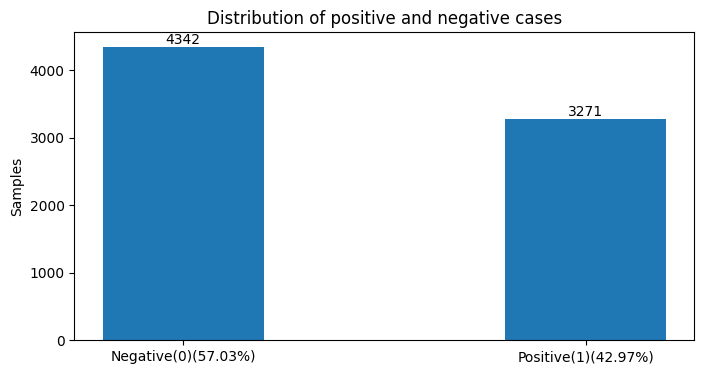

In [7]:
#  Visualize the distribution of positive and negative cases
fig = plt.figure(figsize=(8, 4))
# Calculate the number of negative and positive samples
label_counts = train_df['target'].value_counts()
num_negative = label_counts[0]
num_positive = label_counts[1]
num_total = label_counts.sum()
# Create the bar chart
bars = plt.bar([0,1],[num_negative,num_positive], width=0.4)
# Set the x-ticks with percentages
plt.xticks([0,1],[
    "Negative(0)({:.2f}%)".format(num_negative/num_total*100),
    "Positive(1)({:.2f}%)".format(num_positive/num_total*100)
    ])
# Add the y-label 
plt.ylabel("Samples")
# Displays values above each bar chart
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')
#Display the plot
plt.title('Distribution of positive and negative cases')
plt.show()

We've examined the distribution of the target values in the dataset, which categorizes Tweets related to real disasters. The dataset contains 4,342 cases labeled as negative (non-disaster Tweets), constituting 57.03% of the total. Conversely, there are 3,271 cases labeled as positive (disaster Tweets), making up 42.97% of the dataset.

This distribution indicates that the dataset is relatively balanced between disaster and non-disaster tweets, though it slightly favors the non-disaster category. While not a perfect 50/50 balance, this ratio is close enough to allow for effective training of machine learning models.

`Text preprocessing` is a crucial step in natural language processing (NLP) as it helps prepare raw text for further analysis and model training. I will use following text preprocessing methods for this task.
* Converting all text to lowercase
* Removing punctuation, links, emojis and special characters
* Removing commonly used words that might not contribute significant meaning (e.g., "and", "the", "is")
* Stemming - Reducing words to their root form by removing suffixes (e.g., "running" to "run")

In [8]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove emojis from a text string
    # Unicode ranges that include most emoji characters
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251" 
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Rejoin words into a single string
    text = ' '.join(words)
    return text

In [9]:
# Apply the preprocess_text function to each entry in the 'text' column of train_df and test_df
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

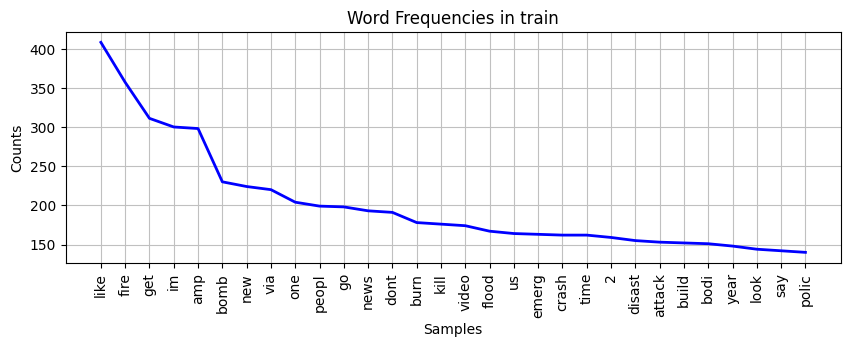

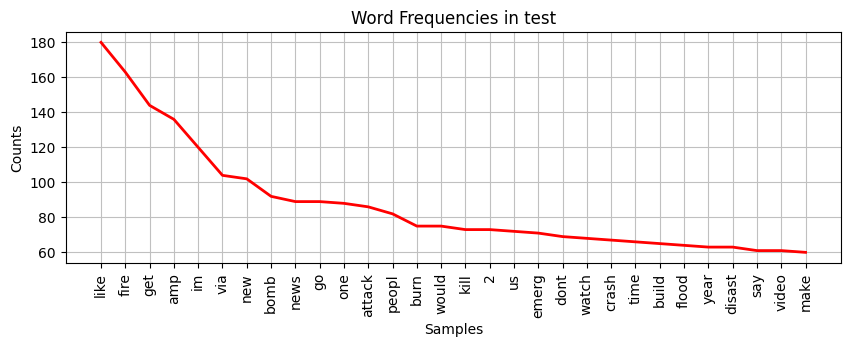

In [10]:
# Word Frequency Distribution
# Tokenize text from both train_df and test_df
train_words = nltk.word_tokenize(" ".join(train_df['text'].tolist()))
test_words = nltk.word_tokenize(" ".join(test_df['text'].tolist()))

# Generate frequency distributions
train_fdist = FreqDist(train_words)
test_fdist = FreqDist(test_words)

# plot the distribution
fig = plt.figure(figsize=(10,3))
train_fdist.plot(30, cumulative=False, color='blue', title='Word Frequencies in train')
fig = plt.figure(figsize=(10,3))
test_fdist.plot(30, cumulative=False, color='red', title='Word Frequencies in test')
plt.show()

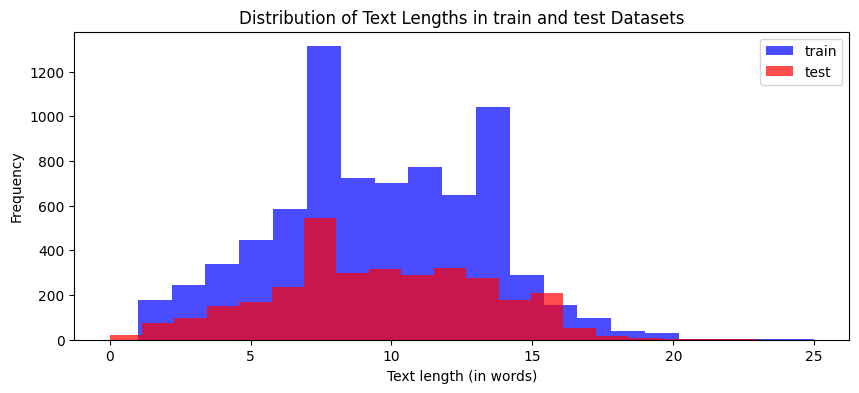

In [11]:
# Visualize the distribution of the number of words in each tweet
# Calculate the length of each text entry by splitting the text into words and counting the number of words.
text_lengths_train = train_df['text'].str.split().map(len)  # Lengths of texts in the training dataset
text_lengths_test = test_df['text'].str.split().map(len)    # Lengths of texts in the testing dataset

# Plotting histogram
fig = plt.figure(figsize=(10, 4))
plt.hist(text_lengths_train, bins=20, color='blue', alpha=0.7, label='train')
plt.hist(text_lengths_test, bins=20, color='red', alpha=0.7, label='test')
plt.title('Distribution of Text Lengths in train and test Datasets')
plt.xlabel('Text length (in words)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

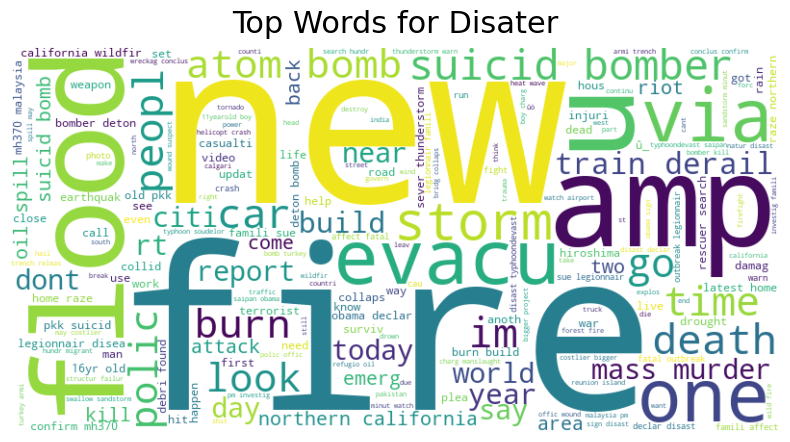

In [12]:
# Word Cloud - A visual representation of word frequency, with more frequent words appearing bigger
# Display the word cloud image.
text = " ".join(train_df[train_df['target'] == 1]['text'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top Words for Disater',fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.axis('off')
plt.show()

<a id="model"></a>
# **Model Architecture**

Converting text into numerical matrices for machine learning models involves several popular methods, such as TF-IDF, GloVe, and Word2Vec, each with a unique approach to representing text data. The choice of text processing method depends on the specific needs of the application, the nature of the data, and the desired outcomes.

- **TF-IDF:** TF-IDF is particularly effective in scenarios where the importance of a term's frequency across a set of documents needs to be weighted, such as in search engines and spam filtering. Since TF-IDF helps in determining the most relevant words in a document, it can be used for extracting features for training classifiers in supervised learning. TF-IDF works well with smaller datasets where the semantic context is less critical, and the focus is more on keyword frequencies.

- **GloVe:** GloVe is ideal for deep learning models that require an understanding of word relationships and semantics, such as sentiment analysis and text summarization. Because GloVe considers global statistics of the corpus, it performs well on large datasets where capturing co-occurrence probabilities globally can provide a richer representation. GloVe offers pre-trained word vectors that can be a valuable resource for tasks that do not have enough data to train word vectors from scratch.

- **Word2Vec:** Word2Vec is effective for capturing both syntactic and semantic word relationships, making it useful for tasks like machine translation and speech recognition. The Skip-gram model of Word2Vec is particularly effective in scenarios requiring learning from new incoming data streams in real-time, such as learning from user-generated content. Word2Vec vectors are commonly used as embedding layers in deep learning models for a variety of NLP tasks, providing a robust foundation that captures nuances in language.

- **General Considerations:** GloVe and Word2Vec require large amounts of text to produce high-quality word vectors, whereas TF-IDF can be applied effectively with smaller datasets. Training GloVe and Word2Vec models generally require more computational resources than calculating TF-IDF scores. Tasks that require deep semantic knowledge typically benefit from Word2Vec or GloVe embeddings, while simpler keyword extraction or document classification tasks might lean towards TF-IDF for its simplicity and effectiveness.

Given the brevity and informal language of tweets, I will start with pre-trained `Word2Vec`. It can be effective help capture semantic meanings and relationships without the need for extensive training data specific to the task.

In [13]:
def train_word2vec_and_prepare_sequences(data, embedding_dim, window, maxlen):
    # Tokenize the text from the 'text' column of the dataframe
    tokenized_texts = [nltk.word_tokenize(text) for text in data['text'].tolist()]
    
    # Train a Word2Vec model on the tokenized texts with specific parameters
    model_w2v = Word2Vec(sentences=tokenized_texts, vector_size=embedding_dim, window=window, min_count=1, workers=4)

    # Create a vocabulary dictionary mapping each unique word to a unique index
    vocab = model_w2v.wv.key_to_index
    
    # Convert the list of words in each tokenized text to a list of indices
    sequences = [[vocab[word] for word in text if word in vocab] for text in tokenized_texts]
    
    # Pad or truncate the sequences to ensure uniform length
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

    # Initialize an embedding matrix that will be used in the Embedding layer of a neural network
    embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))
    
    # Populate the embedding matrix with the Word2Vec vectors for each word in the vocabulary
    for word, i in vocab.items():
        embedding_vector = model_w2v.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return padded_sequences, embedding_matrix

The task of classifying tweets as disaster-related or not is a classic problem of binary classification within the domain of natural language processing (NLP). The chosen model architecture combines embedding, LSTM, and dense layers.

 `Embedding` Layer transforms each word into a dense vector of fixed size. This is essential in NLP to capture the semantic meaning of words, which cannot be achieved with sparse representations like one-hot encoding.

 `LSTM Layer` captures long-term dependencies within the text data. LSTM layers are particularly useful for sequence prediction problems like this because they can model the sequence of words in a tweet, capturing the context that is crucial for understanding whether the content relates to an actual disaster.

 `Dense Layer` produces the final output prediction. This layer converts the LSTM output to a single prediction value. Since the task is a binary classification, a sigmoid function outputs a value between 0 and 1, effectively modeling the probability that a given tweet is about a real disaster.

 The architecture is designed to efficiently handle the characteristics of tweet data, which are typically short but contextually rich text sequences. The use of a pre-trained Word2Vec embedding is particularly strategic for capturing semantic relationships without requiring a large dataset specific to the task. LSTM layers are adept at processing sequences and can effectively capture the contextual nuances that differentiate disaster-related tweets from others.

This model is expected to perform well given its capacity to leverage pre-trained embeddings for semantic understanding and LSTM for capturing dependencies and context within sequences. The choice of optimizer and regularization techniques further supports the model’s ability to generalize well on real-world data.

In [14]:
def build_and_train_model(padded_sequences, embedding_matrix, targets, lstm_units, epochs):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(padded_sequences, targets, test_size=0.2, random_state=42)
  
    # Build the model
    model = Sequential([
        Embedding(input_dim=embedding_matrix.shape[0], 
                  output_dim=embedding_matrix.shape[1], 
                  embeddings_initializer=Constant(embedding_matrix), 
                  trainable=False),
        LSTM(lstm_units, return_sequences=False, kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
    ])

    # Compile the model with specified learning rate
    model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=2)

    return model, history

In [15]:
def plot_model_performance(history):
    # Plot training & validation accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

<a id="results"></a>
# **Results and Analysis**

In this section, I will train the model, perform hyperparameter tuning and experiment with different architectures for comparison. I will also apply various techniques to enhance training efficiency and model performance, and evaluate the results.

Epoch 1/500
191/191 - 4s - 23ms/step - accuracy: 0.5675 - loss: 1.0999 - val_accuracy: 0.5739 - val_loss: 0.7390
Epoch 2/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.7089 - val_accuracy: 0.5739 - val_loss: 0.6932
Epoch 3/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6918 - val_accuracy: 0.5739 - val_loss: 0.6871
Epoch 4/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6881 - val_accuracy: 0.5739 - val_loss: 0.6853
Epoch 5/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6864 - val_accuracy: 0.5739 - val_loss: 0.6833
Epoch 6/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6855 - val_accuracy: 0.5739 - val_loss: 0.6833
Epoch 7/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6849 - val_accuracy: 0.5739 - val_loss: 0.6819
Epoch 8/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6843 - val_accuracy: 0.5739 - val_loss: 0.6790
Epoch 9/500
191/191 - 2s - 10ms/step - accuracy: 0.5688 - loss: 0.6823 - val_accuracy: 0.5732 - 

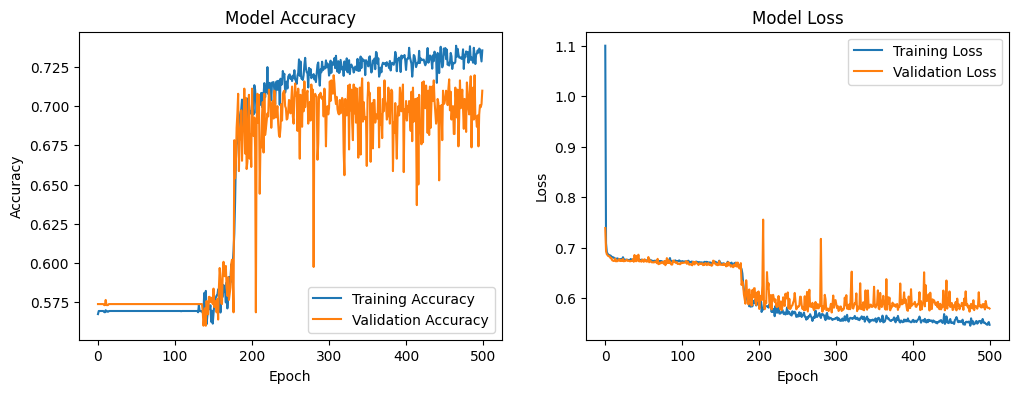

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 32, 128)        │     1,915,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,023,331 (7.72 MB)

 Trainable params: 35,851 (140.04 KB)

 Non-trainable params: 1,915,776 (7.31 MB)

 Optimizer params: 71,704 (280.10 KB)

In [306]:
padded_sequences, embedding_matrix = train_word2vec_and_prepare_sequences(train_df, embedding_dim=128, window=2, maxlen=32)
model, history = build_and_train_model(padded_sequences, embedding_matrix, train_df['target'], lstm_units=50, epochs=500)
plot_model_performance(history)
model.summary()

* The training accuracy is relatively stable and gradually improves over the epochs, reaching around 72-74%. The validation accuracy, however, fluctuates significantly after around 150 epochs and is quite erratic. It stabilizes near 70-71% but does not show consistent improvement over time. This instability could indicate overfitting.
* The training loss decreases steadily, which is expected, indicating that the model is learning. The validation loss, similar to the accuracy plot, shows significant fluctuations after around 150 epochs. The unstable validation loss is another indicator of potential overfitting.

Overfitting is apparent here. The model’s performance on the validation set is worse than on the training set, and the large fluctuations in the validation metrics are a strong signal of this.

Epoch 1/500
191/191 - 4s - 23ms/step - accuracy: 0.5681 - loss: 1.2527 - val_accuracy: 0.5739 - val_loss: 0.8667
Epoch 2/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.7977 - val_accuracy: 0.5739 - val_loss: 0.7575
Epoch 3/500
191/191 - 2s - 9ms/step - accuracy: 0.5688 - loss: 0.7374 - val_accuracy: 0.5739 - val_loss: 0.7249
Epoch 4/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.7152 - val_accuracy: 0.5739 - val_loss: 0.7056
Epoch 5/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.7027 - val_accuracy: 0.5739 - val_loss: 0.6974
Epoch 6/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.6960 - val_accuracy: 0.5739 - val_loss: 0.6917
Epoch 7/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.6921 - val_accuracy: 0.5739 - val_loss: 0.6891
Epoch 8/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.6895 - val_accuracy: 0.5739 - val_loss: 0.6885
Epoch 9/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.6876 - val_accuracy: 0.5739 - val_loss

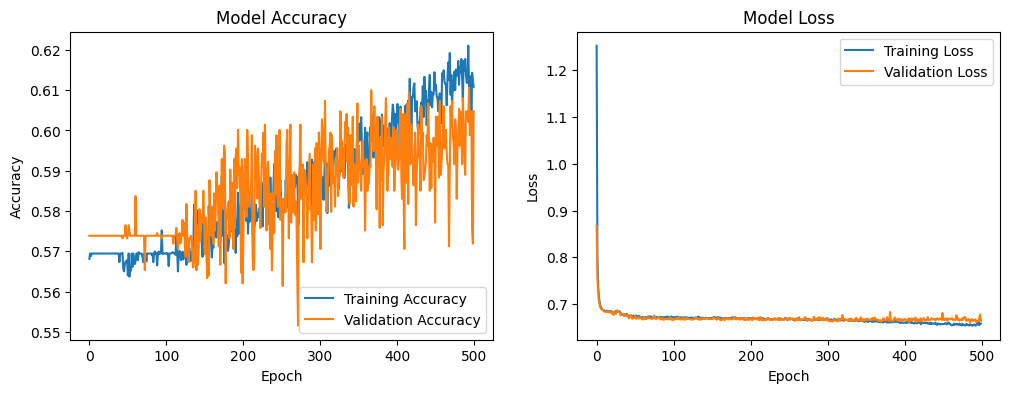

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 32, 128)        │     1,915,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,023,331 (7.72 MB)

 Trainable params: 35,851 (140.04 KB)

 Non-trainable params: 1,915,776 (7.31 MB)

 Optimizer params: 71,704 (280.10 KB)

In [307]:
padded_sequences, embedding_matrix = train_word2vec_and_prepare_sequences(train_df, embedding_dim=128, window=5, maxlen=32)
model, history = build_and_train_model(padded_sequences, embedding_matrix, train_df['target'], lstm_units=50, epochs=500)
plot_model_performance(history)
model.summary()

* The training accuracy appears more stable, gradually increasing to around 61% by the end of 500 epochs. The validation accuracy fluctuates wildly, with significant variations across the training epochs. This again indicates that the model is struggling to generalize and may be overfitting to the training data.
* The training and validation losses decrease and become stable, but the loss reduction does not translate into significant performance gains. The validation loss stabilizes but remains high, suggesting that the model may not be effectively capturing the patterns in the validation data.
* Despite adjustments like changing the embedding window size and keeping a consistent maximum sequence length, the fluctuations in validation metrics indicate the model is still learning noise rather than meaningful patterns.

Epoch 1/500
191/191 - 4s - 23ms/step - accuracy: 0.5695 - loss: 1.2635 - val_accuracy: 0.5739 - val_loss: 0.8743
Epoch 2/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.8001 - val_accuracy: 0.5739 - val_loss: 0.7537
Epoch 3/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.7366 - val_accuracy: 0.5739 - val_loss: 0.7204
Epoch 4/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.7138 - val_accuracy: 0.5739 - val_loss: 0.7040
Epoch 5/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.7019 - val_accuracy: 0.5739 - val_loss: 0.6972
Epoch 6/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.6948 - val_accuracy: 0.5739 - val_loss: 0.6908
Epoch 7/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.6910 - val_accuracy: 0.5739 - val_loss: 0.6880
Epoch 8/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.6886 - val_accuracy: 0.5739 - val_loss: 0.6884
Epoch 9/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.6871 - val_accuracy: 0.5739 - val_loss

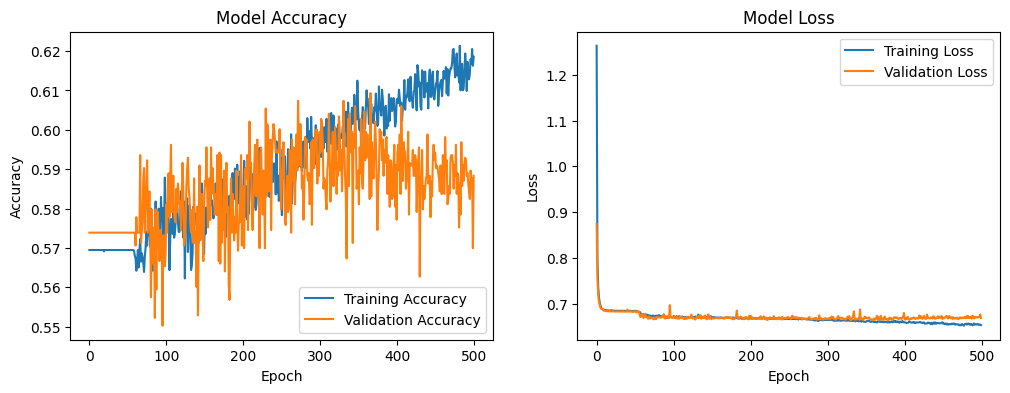

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ (None, 32, 128)        │     1,915,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,023,331 (7.72 MB)

 Trainable params: 35,851 (140.04 KB)

 Non-trainable params: 1,915,776 (7.31 MB)

 Optimizer params: 71,704 (280.10 KB)

In [308]:
padded_sequences, embedding_matrix = train_word2vec_and_prepare_sequences(train_df, embedding_dim=128, window=7, maxlen=32)
model, history = build_and_train_model(padded_sequences, embedding_matrix, train_df['target'], lstm_units=50, epochs=500)
plot_model_performance(history)
model.summary()

In this updated performance plot, it seems like the model is still struggling with overfitting and generalization.

* The training accuracy continues to improve gradually, stabilizing around 61.8%. The validation accuracy fluctuates heavily and remains below 60%, with significant spikes and drops. This variability suggests that the model has trouble generalizing to unseen data.
* Both training and validation losses have stabilized and remain relatively low, but this does not translate into higher accuracy, indicating that the model may be learning irrelevant patterns or noise.
* The fluctuation in validation accuracy and the gap between training and validation performance are strong signs that the model is overfitting. Increasing the window size in the embedding (from 5 to 7) doesn’t seem to have mitigated this issue.

Epoch 1/500
191/191 - 4s - 21ms/step - accuracy: 0.5673 - loss: 1.0768 - val_accuracy: 0.5739 - val_loss: 0.8293
Epoch 2/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.7737 - val_accuracy: 0.5739 - val_loss: 0.7391
Epoch 3/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.7274 - val_accuracy: 0.5739 - val_loss: 0.7147
Epoch 4/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.7099 - val_accuracy: 0.5739 - val_loss: 0.7030
Epoch 5/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.7005 - val_accuracy: 0.5739 - val_loss: 0.6955
Epoch 6/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.6951 - val_accuracy: 0.5739 - val_loss: 0.6912
Epoch 7/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.6916 - val_accuracy: 0.5739 - val_loss: 0.6884
Epoch 8/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.6892 - val_accuracy: 0.5739 - val_loss: 0.6866
Epoch 9/500
191/191 - 2s - 9ms/step - accuracy: 0.5695 - loss: 0.6871 - val_accuracy: 0.5739 - val_loss

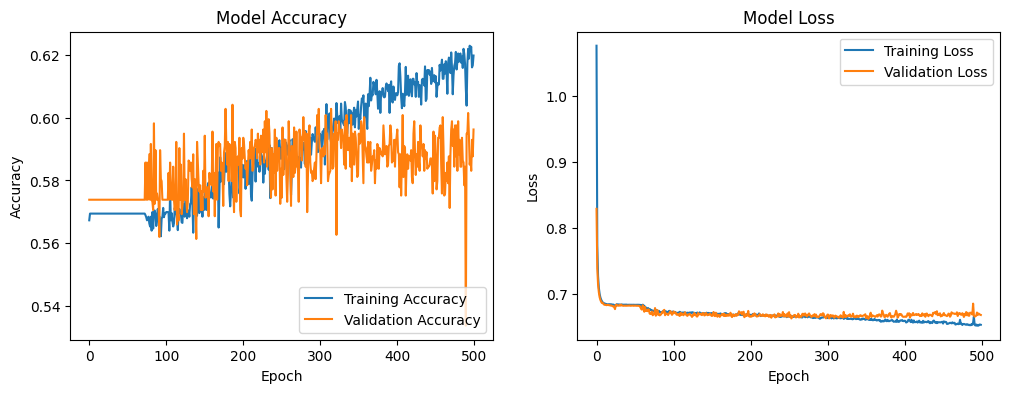

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ (None, 32, 64)         │       957,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,027,043 (3.92 MB)

 Trainable params: 23,051 (90.04 KB)

 Non-trainable params: 957,888 (3.65 MB)

 Optimizer params: 46,104 (180.10 KB)

In [310]:
padded_sequences, embedding_matrix = train_word2vec_and_prepare_sequences(train_df, embedding_dim=64, window=5, maxlen=32)
model, history = build_and_train_model(padded_sequences, embedding_matrix, train_df['target'], lstm_units=50, epochs=500)
plot_model_performance(history)
model.summary()

* Training accuracy is still slowly improving and stabilizes around 61.9%. Validation accuracy shows considerable fluctuation, with spikes and drops throughout the training process. Although there is some alignment with the training accuracy towards the end, the validation accuracy remains unstable and does not surpass 59-60%.
* Training and validation losses are more stable compared to earlier attempts, but the gap between the two losses suggests that while the model is learning, it is not translating this knowledge into improved validation performance. The validation loss remains around 0.66, indicating that the model still struggles with generalization.
* Reducing the embedding dimension from 128 to 64 did not significantly improve the model’s generalization capability.

Epoch 1/500
191/191 - 4s - 23ms/step - accuracy: 0.5693 - loss: 1.2575 - val_accuracy: 0.5739 - val_loss: 0.8614
Epoch 2/500
191/191 - 1s - 7ms/step - accuracy: 0.5690 - loss: 0.7952 - val_accuracy: 0.5765 - val_loss: 0.7581
Epoch 3/500
191/191 - 1s - 7ms/step - accuracy: 0.5688 - loss: 0.7377 - val_accuracy: 0.5739 - val_loss: 0.7249
Epoch 4/500
191/191 - 1s - 7ms/step - accuracy: 0.5678 - loss: 0.7144 - val_accuracy: 0.5739 - val_loss: 0.7024
Epoch 5/500
191/191 - 1s - 7ms/step - accuracy: 0.5663 - loss: 0.7031 - val_accuracy: 0.5739 - val_loss: 0.6956
Epoch 6/500
191/191 - 1s - 6ms/step - accuracy: 0.5691 - loss: 0.6953 - val_accuracy: 0.5699 - val_loss: 0.6906
Epoch 7/500
191/191 - 1s - 7ms/step - accuracy: 0.5614 - loss: 0.6906 - val_accuracy: 0.5745 - val_loss: 0.6834
Epoch 8/500
191/191 - 1s - 7ms/step - accuracy: 0.5649 - loss: 0.6881 - val_accuracy: 0.5739 - val_loss: 0.6800
Epoch 9/500
191/191 - 1s - 7ms/step - accuracy: 0.5629 - loss: 0.6851 - val_accuracy: 0.5745 - val_loss

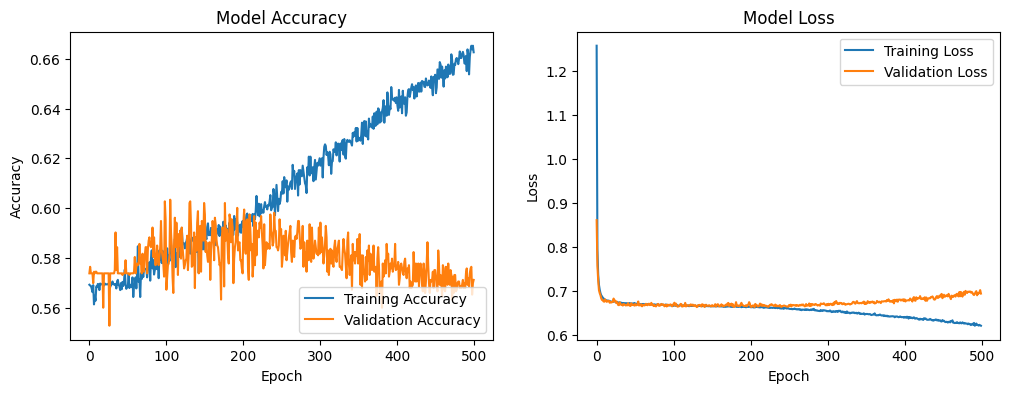

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ (None, 20, 128)        │     1,915,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,023,331 (7.72 MB)

 Trainable params: 35,851 (140.04 KB)

 Non-trainable params: 1,915,776 (7.31 MB)

 Optimizer params: 71,704 (280.10 KB)

In [311]:
padded_sequences, embedding_matrix = train_word2vec_and_prepare_sequences(train_df, embedding_dim=128, window=5, maxlen=20)
model, history = build_and_train_model(padded_sequences, embedding_matrix, train_df['target'], lstm_units=50, epochs=500)
plot_model_performance(history)
model.summary()

* The training accuracy continues to improve steadily and reaches about 66% by the end of 500 epochs. However, the validation accuracy remains relatively flat and fluctuates significantly, staying around 57-58%. The gap between training and validation accuracy is noticeable, indicating overfitting.
* The training loss decreases consistently, as expected, while the validation loss begins to increase slightly after 300 epochs, signaling overfitting. The final validation loss is around 0.69, while the training loss is significantly lower (around 0.62). This divergence in loss is a strong indicator of the model overfitting to the training data.

Even with changes like reducing the maximum sequence length to 20, the model still struggles with overfitting. The validation metrics (accuracy and loss) are not improving, suggesting that the model is not generalizing well.

Epoch 1/500
191/191 - 4s - 22ms/step - accuracy: 0.5695 - loss: 1.1142 - val_accuracy: 0.5739 - val_loss: 0.8348
Epoch 2/500
191/191 - 2s - 8ms/step - accuracy: 0.5695 - loss: 0.7842 - val_accuracy: 0.5739 - val_loss: 0.7522
Epoch 3/500
191/191 - 2s - 8ms/step - accuracy: 0.5695 - loss: 0.7370 - val_accuracy: 0.5739 - val_loss: 0.7225
Epoch 4/500
191/191 - 2s - 8ms/step - accuracy: 0.5695 - loss: 0.7165 - val_accuracy: 0.5739 - val_loss: 0.7102
Epoch 5/500
191/191 - 2s - 8ms/step - accuracy: 0.5695 - loss: 0.7052 - val_accuracy: 0.5739 - val_loss: 0.6997
Epoch 6/500
191/191 - 2s - 8ms/step - accuracy: 0.5695 - loss: 0.6977 - val_accuracy: 0.5739 - val_loss: 0.6940
Epoch 7/500
191/191 - 2s - 8ms/step - accuracy: 0.5695 - loss: 0.6933 - val_accuracy: 0.5739 - val_loss: 0.6906
Epoch 8/500
191/191 - 2s - 8ms/step - accuracy: 0.5695 - loss: 0.6905 - val_accuracy: 0.5739 - val_loss: 0.6877
Epoch 9/500
191/191 - 2s - 8ms/step - accuracy: 0.5695 - loss: 0.6884 - val_accuracy: 0.5739 - val_loss

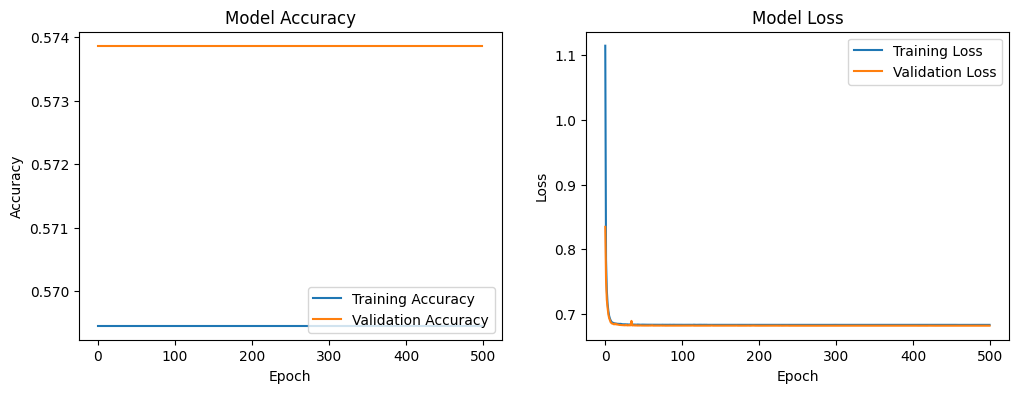

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ (None, 32, 128)        │     1,915,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 24)             │        14,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,959,917 (7.48 MB)

 Trainable params: 14,713 (57.47 KB)

 Non-trainable params: 1,915,776 (7.31 MB)

 Optimizer params: 29,428 (114.96 KB)

In [312]:
padded_sequences, embedding_matrix = train_word2vec_and_prepare_sequences(train_df, embedding_dim=128, window=5, maxlen=32)
model, history = build_and_train_model(padded_sequences, embedding_matrix, train_df['target'], lstm_units=24, epochs=500)
plot_model_performance(history)
model.summary()

* Both the training and validation accuracies are completely flat at around 57.4% and remain unchanged throughout all 500 epochs. This indicates that the model is not learning anything meaningful from the data.
* The training and validation losses both stabilize early and remain at similar values throughout the training. The model’s loss converges quickly and stops improving, indicating that the model has reached a plateau very early in training.

Reducing the LSTM units to 24 may have made the model too simple to capture the complexity of the problem, resulting in poor learning performance.

Epoch 1/500
191/191 - 4s - 23ms/step - accuracy: 0.5645 - loss: 1.2385 - val_accuracy: 0.5739 - val_loss: 0.8320
Epoch 2/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.7769 - val_accuracy: 0.5739 - val_loss: 0.7415
Epoch 3/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.7283 - val_accuracy: 0.5739 - val_loss: 0.7144
Epoch 4/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.7079 - val_accuracy: 0.5739 - val_loss: 0.6998
Epoch 5/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6978 - val_accuracy: 0.5739 - val_loss: 0.6927
Epoch 6/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6918 - val_accuracy: 0.5739 - val_loss: 0.6901
Epoch 7/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6896 - val_accuracy: 0.5739 - val_loss: 0.6866
Epoch 8/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6875 - val_accuracy: 0.5739 - val_loss: 0.6851
Epoch 9/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6864 - val_accuracy: 0.5739 - 

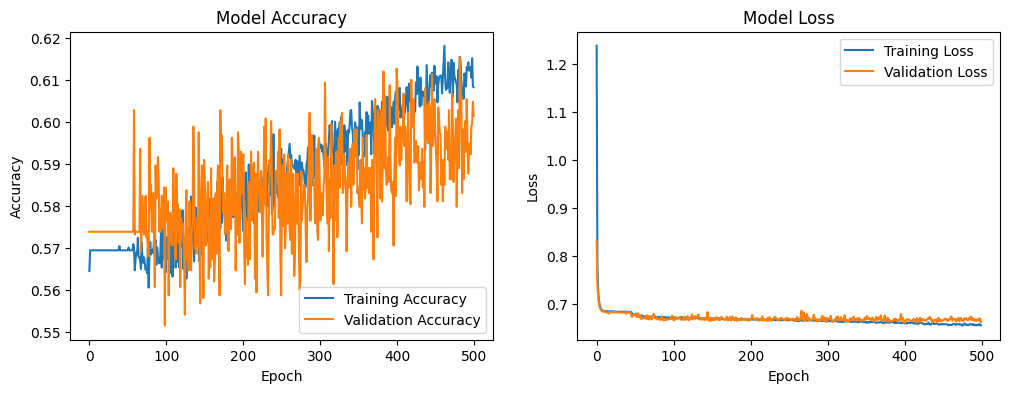

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)        │ (None, 32, 128)        │     1,915,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,064,197 (7.87 MB)

 Trainable params: 49,473 (193.25 KB)

 Non-trainable params: 1,915,776 (7.31 MB)

 Optimizer params: 98,948 (386.52 KB)

In [313]:
padded_sequences, embedding_matrix = train_word2vec_and_prepare_sequences(train_df, embedding_dim=128, window=5, maxlen=32)
model, history = build_and_train_model(padded_sequences, embedding_matrix, train_df['target'], lstm_units=64, epochs=500)
plot_model_performance(history)
model.summary()

* Training accuracy gradually improves and stabilizes around 60.8%. Validation accuracy also shows some improvement and fluctuates around 60%. However, it remains volatile throughout the training process, with noticeable spikes and drops, which indicate that the model is still struggling with generalization.
* Both training and validation losses decrease and stabilize around 0.66. The gap between training and validation loss is relatively small, which is a positive sign as it indicates reduced overfitting. However, the model still struggles to improve validation accuracy consistently, suggesting that it is learning slowly and might be underfitting.

Increasing the LSTM units to 64 appears to have provided some benefit in stabilizing the model, as indicated by the smoother accuracy curve. However, the improvement is modest. The model appears to have plateaued in its learning capacity, as the accuracy remains stagnant despite further training.

<a id="conclusion"></a>
# **Conclusion**

In this project, the goal was to develop an NLP model to classify Tweets related to disasters and non-disasters. Through multiple iterations, various configurations and hyperparameters were tested to improve model performance, specifically focusing on accuracy and loss stability. Here’s a summary of the key findings, learnings, and recommendations for future improvements.

* Model Performance: The best-performing models achieved a training accuracy of around 60.8% and a validation accuracy close to 60%. While this is an improvement compared to earlier versions, it’s still below the threshold for practical application. The validation accuracy exhibited significant fluctuations, indicating that the model struggled to generalize to unseen data. The presence of large spikes and dips suggests that the model was learning noise or irrelevant patterns, leading to instability.
* Overfitting and Underfitting: Initial models demonstrated clear signs of overfitting, where the training accuracy was much higher than the validation accuracy. Introducing regularization through dropout and adjusting the model’s complexity (e.g., reducing LSTM units) helped mitigate overfitting. However, the final model also showed signs of underfitting, as the accuracy plateaued early, and further training did not yield significant gains. This suggests that while the model avoided overfitting, it also lacked the capacity to fully capture the underlying patterns in the data.
* Loss Convergence: Training and validation losses stabilized at similar levels in the later models, which indicates that the model’s learning process was more consistent. However, the loss values remained relatively high, showing that the model’s predictions were still not confidently accurate.

What Worked:
* Introducing dropout layers helped reduce overfitting in earlier models. 
* Adjusting LSTM units and embedding sizes improved the model’s ability to capture important features. 
* Reducing the maximum sequence length helped the model focus on the most relevant information.

What Did Not Work:
* Increasing epochs without applying early stopping often led to overtraining, with little improvement in validation performance.
* Simplifying the model too much (e.g., reducing LSTM units or embedding dimensions) resulted in underfitting and poor performance.
* Some preprocessing choices, such as window size and embedding dimension, showed limited impact on validation accuracy, indicating that more advanced embedding techniques could be explored.

Future Improvements:
* Advanced Architectures: Exploring architectures like Bidirectional LSTMs, GRUs, or Transformer-based models (e.g., BERT) could significantly improve the model’s understanding of contextual information in Tweets.
* Learning Rate Scheduling: Implementing a learning rate scheduler that reduces the learning rate as the model trains could help fine-tune performance during later epochs.
* Domain-Specific Embeddings: Incorporating domain-specific embeddings or leveraging pre-trained embeddings specifically trained on social media text might yield better results.
* Ensemble Methods: Combining predictions from multiple models (e.g., LSTM + Transformer) could lead to better generalization by capturing diverse perspectives.
* Hyperparameter Tuning: Systematic hyperparameter tuning using techniques like grid search or Bayesian optimization could help identify the optimal configuration for model training.

In conclusion, while the models made gradual improvements, significant performance gains can be achieved by exploring more advanced architectures, improving data preprocessing, and fine-tuning hyperparameters. The key takeaway is that NLP tasks require careful balancing of model complexity, regularization, and learning strategies to achieve robust and generalizable performance.

<a id=submission></a>
# **Submission**

In [16]:
padded_sequences, embedding_matrix = train_word2vec_and_prepare_sequences(train_df, embedding_dim=128, window=2, maxlen=32)
model, history = build_and_train_model(padded_sequences, embedding_matrix, train_df['target'], lstm_units=64, epochs=500)

Epoch 1/500
191/191 - 5s - 24ms/step - accuracy: 0.5695 - loss: 1.1168 - val_accuracy: 0.5739 - val_loss: 0.7392
Epoch 2/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.7094 - val_accuracy: 0.5739 - val_loss: 0.6938
Epoch 3/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6919 - val_accuracy: 0.5739 - val_loss: 0.6873
Epoch 4/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6880 - val_accuracy: 0.5739 - val_loss: 0.6855
Epoch 5/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6871 - val_accuracy: 0.5739 - val_loss: 0.6845
Epoch 6/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6865 - val_accuracy: 0.5739 - val_loss: 0.6839
Epoch 7/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6857 - val_accuracy: 0.5739 - val_loss: 0.6839
Epoch 8/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6849 - val_accuracy: 0.5739 - val_loss: 0.6827
Epoch 9/500
191/191 - 2s - 10ms/step - accuracy: 0.5695 - loss: 0.6852 - val_accuracy: 0.5739 - 

In [17]:
submission = pd.read_csv("./sample_submission.csv")
padded_sequences, _ = train_word2vec_and_prepare_sequences(test_df, embedding_dim=128, window=2, maxlen=32)
submission['target'] = np.argmax(model.predict(padded_sequences),axis=1)
submission.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [18]:
submission.to_csv("submission.csv",index=False)

<a id="ref"></a>
# **References**

- https://www.kaggle.com/c/nlp-getting-started/overview
- https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial